# 2.1 - Model Evaluation

In this notebook, we conduct baseline and enriched pipeline evaluation on the filtered dataset.

## Setup

### Libraries

In [9]:
# utility
from datetime import datetime
from dotenv import load_dotenv
import os
import re
from tqdm import tqdm

# langchain
from langchain.prompts.chat import (
    ChatPromptTemplate,
    SystemMessagePromptTemplate,
    HumanMessagePromptTemplate,
)
from langchain.chat_models import AzureChatOpenAI
from langchain.schema import AIMessage, HumanMessage, SystemMessage

# data manipulation
import pandas as pd
import numpy as np

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
# load environment variables
load_dotenv("../.env")

True

In [11]:
OPENAI_API_TYPE = os.environ["OPENAI_API_TYPE"]
OPENAI_API_VERSION = os.environ["OPENAI_API_VERSION"]
OPENAI_API_BASE = os.environ["OPENAI_API_BASE"]
OPENAI_API_KEY = os.environ["OPENAI_API_KEY"]
DEPLOYMENT_NAME = os.environ["DEPLOYMENT_NAME"]
MODEL_NAME = "gpt-35-turbo"

### Data

Load the filtered version of the Autocast dataset.

In [12]:
DATA_DIR = "../data"
DATA_FILE_NAME = "test_df_latest.json"
DATA_PATH = os.path.join(DATA_DIR, DATA_FILE_NAME)

In [13]:
def build_file_name(df, description=None):
    current_time = datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
    df_size = df.shape[0]
    file_name = f"test_df-{current_time}-size_{df_size}"
    
    if description is not None:
        file_name += f"-{description}"
    
    file_ext = ".json"
    file_name += file_ext
    
    return file_name

def save_test_df(df, file_name=None, data_dir=DATA_DIR, description=None):
    if file_name is None:
        file_name = build_file_name(df, description)
    
    file_path = os.path.join(data_dir, file_name)
    
    df.to_json(file_path, orient="records", lines=True)
    print(f"Saved test dataframe to: {file_path}")

In [14]:
test_df = pd.read_json(DATA_PATH, orient="records", lines=True)

In [15]:
print(f"Test dataframe shape: {test_df.shape}")
print("")

test_df.info()

Test dataframe shape: (98, 27)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98 entries, 0 to 97
Data columns (total 27 columns):
 #   Column                          Non-Null Count  Dtype              
---  ------                          --------------  -----              
 0   question                        98 non-null     object             
 1   id                              98 non-null     object             
 2   background                      98 non-null     object             
 3   publish_time                    98 non-null     datetime64[ns]     
 4   close_time                      98 non-null     datetime64[ns, UTC]
 5   tags                            98 non-null     object             
 6   source_links                    98 non-null     object             
 7   prediction_count                98 non-null     int64              
 8   forecaster_count                98 non-null     int64              
 9   answer                          0 non-null      float64  

In [16]:
test_df.head(3)

,question,id,background,publish_time,close_time,tags,source_links,prediction_count,forecaster_count,answer,...,pred_taken,acceptable_pred_lower_boundary,acceptable_pred_upper_boundary,context,examples,best_example,lowest_uncertainty,highest_uncertainty,average_uncertainty,external_context
0,Will there be a complex coordinated terrorist ...,G2124,CCTAs are a major concern for law enforcement ...,2021-09-17 15:49:41.402,2022-09-01 07:01:00+00:00,"[Society, Security and Conflict]",[],340,111,NaN,...,0.05,-0.15,0.25,Entities:\n- Complex coordinated terrorist att...,[{'example_question': 'Between 1 January 2018 ...,{'example_question': 'Will the government of C...,0,0.45,0.082,The United States remains in a heightened thre...
1,"Before 1 September 2022, will Egypt, Ethiopia,...",G2125,"Tensions between Egypt, Ethiopia, and Sudan co...",2021-09-17 15:49:44.237,2022-09-01 07:01:00+00:00,"[Foreign Policy, Security and Conflict, Non-US...",[https://www.securitycouncilreport.org/whatsin...,166,59,NaN,...,0.05,-0.15,0.25,"Entities:\n- Egypt: a country in North Africa,...",[{'example_question': 'Will the EU amend its O...,{'example_question': 'Will either Turkey or Ru...,0,0.50,0.104,"As of August 2021, the foreign ministers of Eg..."
2,"Before 1 January 2023, will the Taipei Economi...",G2141,Recent media reporting indicates discussions r...,2021-09-30 14:38:57.362,2023-01-01 08:01:00+00:00,"[Foreign Policy, US Politics, Security and Con...",[],188,51,NaN,...,0.16,-0.04,0.36,Entities:\n- Taipei Economic and Cultural Repr...,[{'example_question': 'Between 18 October and ...,{'example_question': 'Will the New START treat...,0,0.35,0.040,The Taipei Economic and Cultural Representativ...


### Filter Data

In [17]:
def build_sample_df(df, qtypes=["t/f", "mc"], n=100):
    """
    Build a sample dataframe with a fixed number of samples per question type.
    """
    sample_df = pd.DataFrame()
    for qtype in qtypes:
        sample_df = pd.concat([sample_df, df[df["qtype"] == qtype].sample(n=n, random_state=1)])
    sample_df = sample_df.sample(frac=1, random_state=1)
    return sample_df

def filter_df_by_vals(df: pd.DataFrame, filter_dict: dict) -> pd.DataFrame:
    """
    Filters a dataframe based on a filter dictionary where the keys are dataframe
    columns and the values are used to filter each column.

    Args:
        filter_dict (dict): filter dictionary
        df (pd.DataFrame): dataframe
    """
    df_filtered = df.copy()
    for key, value in filter_dict.items():
        df_filtered = df_filtered[df_filtered[key] == value]
    return df_filtered

def filter_df_by_tag(df: pd.DataFrame, tag_col: str, filter_tag: str) -> pd.DataFrame:
    """
    Filters a dataframe based on whether filter_tag appears in the list of tags
    located in tag_col.

    Args:
        tag_col (str): tag column
        filter_tag (str): tag
        df (pd.DataFrame): dataframe
    """
    df_filtered = df.copy()
    df_filtered = df_filtered[df_filtered[tag_col].apply(lambda x: filter_tag in x)]
    return df_filtered

In [18]:
# filter df so qtype column is only t/f or mc
test_df = test_df[test_df["qtype"].isin(["t/f", "mc"])]

# filter for active questions only
test_df = test_df[test_df["status"] == "Active"]
test_df = test_df[test_df["choices"].notna()]

# drop duplicates
test_df = test_df.drop_duplicates(subset=['id', 'question'])

# print shape
print(f"Test dataframe has shape: {test_df.shape}")

Test dataframe has shape: (98, 27)


## Baseline

We use Azure OpenAI services and a deployed GPT 3.5 chat completion model to generate predictions using a top K method.

In [19]:
def build_results_data_name(df, model_name: str = MODEL_NAME,  description: str = None):
    """
    Builds a name for the results data file.

    Args:
        df (pandas.DataFrame): A dataframe with experiment results.
        model_name (str): The name of the model.
        description (str): A description of the results data.
    """
    timestamp = datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
    df_size = df.shape[0]
    
    save_name = f"{model_name}_{timestamp}_results-{df_size}"
    
    if description is not None:
        save_name += f"_{description}"

    extension = "json"
    save_name += f".{extension}"
    
    return save_name

def save_results_data_json(df, model_name=MODEL_NAME, data_dir="../data", save_path=None):
    """
    Saves a results dataframe to a JSON file.

    Args:
        df (pandas.DataFrame): A dataframe with experiment results.
        model_name (str): The name of the model.
        data_dir (str): The directory to save the JSON file to.
        save_path (str): The path to save the JSON file to.
    """
    if save_path is None:
        save_name = build_results_data_name(df, model_name=model_name)
        save_path = os.path.join(data_dir, save_name)
        
    df.to_json(save_path, orient="records", indent=4)
    print(f"Saved results to: {save_path}")

def describe_question_row_by_idx(df, idx):
    """
    Prints the question and choices for a given row in a dataframe.

    Args:
        df (pd.DataFrame): A dataframe of questions.
        idx (int): The index of the row to describe.
    """
    row = df.iloc[idx]
    print(f"Question:\n{row['question']}\n")
    
    print("Choices:")
    for i, choice in enumerate(row["choices"]):
        print(f"{chr(65 + i)} - {choice}")
    print("")

    print("Crowd:")
    print(f"Majority: {row['majority_pred']}")
    
    lower_bound = row['acceptable_pred_lower_boundary']
    upper_bound = row['acceptable_pred_upper_boundary']
    print(f"Acceptable range: ({round(lower_bound, 3)}, {round(upper_bound, 3)})")

In [20]:
class Forecaster():
    def __init__(self, chat, prompt: str):
        """
        A class for forecasting answers to questions using a language model.

        Args:
            chat: A chat language model.
            prompt (str): A prompt for the language model.
        """
        self.chat = chat
        self.prompt = prompt
    
    def format_choices(self, choices: list[str]):
        """
        Accepts a list of choices and formats them for the language model
        with a letter for each choice and one choice per line.

        Args:
            choices (list): A list of choices.
        """
        formatted_choices = "\n".join(
            [f"{chr(65 + idx)} - {choice}" for idx, choice in enumerate(choices)]
        )
        return formatted_choices
    
    def valid_answer(self, answer: str):
        """
        Returns True if the answer is valid, False otherwise.

        Args:
            answer (str): An answer.
        """
        # invalid if answer is not a string or is None
        if not isinstance(answer, str) or answer is None:
            return False

        # invalid if first character is not a letter
        if not re.match(r"[A-Z]", answer[0]):
            return False
        
        # invalid if second character is a letter
        if len(answer) > 1 and re.match(r"[A-Z]", answer[1]):
            return False
        
        return True
    
    def clean_answer(self, answer: str):
        """
        If the answer is valid, returns just the first letter of the answer.
        Converts a yes/no answer to a letter, where yes is A and no is B.
        Returns None if the answer is not valid.

        Args:
            answer (str): An answer.
        """
        if not self.valid_answer(answer):
            return None
        
        answer = self.yes_no_to_letter(answer)

        return answer[0]
    
    def idx_from_letter(self, letter: str):
        """
        Converts a letter (A, B, C, etc.) to an index, where A is 0, 
        B is 1, and so on. Returns None if the letter is not valid.

        Args:
            letter (str): A letter.
        """
        if letter is None:
            return None
        
        letter = letter.upper()
        letter = letter.strip()
        letter = re.sub(r"[^A-Z]", "", letter)

        # return None if letter is not valid
        if len(letter) != 1 or ord(letter) < 65 or ord(letter) > 90:
            return None

        return int(ord(letter) - 65)
    
    def yes_no_to_letter(self, answer: str):
        """
        Converts a yes/no answer to a letter, where yes is A and no is B.

        Args:
            answer (str): A yes/no answer.
        """
        if answer is None:
            return answer
        elif answer.lower() == "yes" or answer.lower() == "y":
            return "A"
        elif answer.lower() == "no" or answer.lower() == "n":
            return "B"
        else:
            return answer
        
    def get_llm_response(self, vars: dict):
        """
        Returns a response from the language model in the form of a dictionary
        with the original prediction and the cleaned predicted answer.

        Args:
            vars (dict): A dictionary with the question and choices.
        """
        original_prediction = self.chat(
            self.prompt.format_prompt(**vars).to_messages()
        ).content

        predicted_answer = self.clean_answer(original_prediction)
        
        return {
            "original_prediction": original_prediction,
            "predicted_answer": predicted_answer
        }

    def predict(self, question: str, choices: list[str]):
        """
        Uses the language model to predict an answer to a question and returns
        a dictionary with the question, choices, and predicted answer.

        Args:
            question (str): A question.
            choices (list): A list of choices.
        """
        vars = {
            "question": question,
            "choices": self.format_choices(choices),
        }

        try:
            results = self.get_llm_response(vars)
            original_prediction = results["original_prediction"]
            predicted_answer = results["predicted_answer"]
            predicted_answer_idx = self.idx_from_letter(predicted_answer)
        except Exception as e:
            print(e)
            original_prediction = None
            predicted_answer = None
            predicted_answer_idx = None

        if predicted_answer_idx is None or predicted_answer_idx >= len(choices):
            predicted_answer = None
            predicted_answer_text = None
            predicted_answer_idx = None
        else:
            predicted_answer_text = choices[predicted_answer_idx]

        response = {
            "question": question,
            "choices": choices,
            "original_prediction": original_prediction,
            "predicted_answer": predicted_answer,
            "predicted_answer_idx": predicted_answer_idx,
            "predicted_answer_text": predicted_answer_text
        }

        return response
    
    def predict_df(self, df: pd.DataFrame, id_col: str, question_col: str, choices_col: str):
        """
        Uses the language model to predict answers to a dataframe of questions.
        Returns a dataframe with the question id, question, choices, and predicted answer.

        Args:
            df (pd.DataFrame): A dataframe of questions.
            id_col (str): The name of the column containing the question IDs.
            question_col (str): The name of the column containing the questions.
            choices_col (str): The name of the column containing the choices.
        """

        predictions = []

        for _, row in tqdm(df.iterrows(), total=df.shape[0]):
            question = row[question_col]
            choices = row[choices_col]
            prediction = self.predict(question, choices)
            prediction[id_col] = row[id_col]
            predictions.append(prediction)

        predictions_df = pd.DataFrame(predictions)

        return predictions_df
    
class ForecasterTopK(Forecaster):
    def __init__(self, chat, system_prompt: str, human_prompt: str, k: int = 10):
        """
        A version of the Forecaster class that uses the top-k sampling method
        for generating predictions.

        Args:
            chat: A chat language model.
            system_prompt (str): A prompt for the language model.
            human_prompt (str): A prompt for the language model.
            k (int): The number of predictions to generate.
        """
        self.chat = chat

        self.system_prompt = system_prompt
        self.human_prompt = human_prompt

        self.k = k
        self.chat.n = self.k

    def get_llm_response(self, vars: dict):
        """
        Returns a response from the language model in the form of a dictionary
        with the original prediction and the cleaned predicted answer.

        Args:
            vars (dict): A dictionary with the question and choices.
        """

        batch_messages = [
            [
                self.system_prompt.format_messages()[0],
                self.human_prompt.format_messages(**vars)[0],
            ],
        ]
        result = self.chat.generate(batch_messages)

        original_prediction = [generation.text for generation in result.generations[0]]

        predicted_answers = [self.clean_answer(prediction) 
                             for prediction in original_prediction]
        
        return {
            "original_prediction": original_prediction,
            "top_k_predicted_answers": predicted_answers,
            "predicted_answer": self.majority_choice(predicted_answers)
        }
    
    def majority_choice(self, predicted_answers: list[str]):
        """
        Returns the majority choice from a list of predicted answers.

        Args:
            predicted_answers (list): A list of predicted answers.
        """
        counts = {answer: 0 for answer in predicted_answers}
        for answer in predicted_answers:
            counts[answer] += 1
        majority_answer = max(counts, key=counts.get)
        return majority_answer

    def predict(self, question: str, choices: list[str]):
        """
        Uses the language model to predict an answer to a question and returns
        a dictionary with the question, choices, and predicted answer.

        Args:
            question (str): A question.
            choices (list): A list of choices.
        """
        vars = {
            "question": question,
            "choices": self.format_choices(choices),
        }

        try:
            results = self.get_llm_response(vars)
            original_prediction = results["original_prediction"]
            predicted_answer = results["predicted_answer"]
            predicted_answer_idx = self.idx_from_letter(predicted_answer)
            top_k = results["top_k_predicted_answers"]
        except Exception as e:
            print(e)
            original_prediction = None
            predicted_answer = None
            predicted_answer_idx = None
            top_k = []

        if predicted_answer_idx is None or predicted_answer_idx >= len(choices):
            predicted_answer = None
            predicted_answer_text = None
            predicted_answer_idx = None
        else:
            predicted_answer_text = choices[predicted_answer_idx]

        response = {
            "question": question,
            "choices": choices,
            "original_prediction": original_prediction,
            "predicted_answer": predicted_answer,
            "predicted_answer_idx": predicted_answer_idx,
            "predicted_answer_text": predicted_answer_text,
            "top_k_predicted_answers": top_k
        }

        return response

### Prediction

In [21]:
# set variables for use with OpenAI API
TOP_P_VALUE = 0.8
K_VALUE = 20
MAX_PREDICTION_TOKENS = 32
REQUEST_TIMEOUT = 10

In [22]:
META_PROMPT = """
I am working on a very important forecasting project and you are my helpful forecasting assistant. I will give you a multiple choice question about the future and you should return to me the letter that corresponds to the best choice. Some of the questions are very difficult, but it's still very important to choose the best possible answer from the provided choices. You must never refuse to provide an answer, even if the question is impossible to answer with certainty. If you are not sure about the answer, make your best guess based on available information.

To identify the best possible choice, start by making sure you understand the question. If I have background research, I will provide it to you and you should use that information to better understand the question. If I do not provide background research, then you should think step by step about the relationship between different entities and terms in the question. 

In some cases, I will show you past examples of questions and the correct answers. If you have seen past examples with correct answers, then you can use those to practice and learn how to answer questions accurately. Start by pretending you need to answer those questions. Think step by step through the example question and example choices and try to understand everything about them. Choose what you think is the best answer to the example question and then compare it to the real best answer. If your answer is correct, remember the process you used and apply it to future questions. If your answer is wrong, then think about what you should do differently to get the correct answer. However, remember that every question is independent and the answers to example questions may not be relevant to new questions. It is only the process for finding the best answer that is the same.

I will give you the questions in the below format, where the question, choices, and answer are in double brackets. If I have background research, I will include it in the optional section demarcated by +++.

Question:
{{the question to answer}}

Choices:
A - {{choice 1}}
B - {{choice 2}}
...
n - {{choice n}}

+++
Background Research:
{{useful information about the question}}
+++

{{letter that corresponds to best choice}}

It is extremely important to only give me the letter of the best answer and nothing else. You must never refuse to provide an answer, no matter what. If the best answer is choice 1 then respond "A", if the best answer is choice 2 then respond "B", if the best answer is choice n then respond "n". Do not ever add extra information or stray from this structure.
"""

system_message_prompt = SystemMessagePromptTemplate.from_template(META_PROMPT)

In [23]:
BASELINE_PROMPT = """
Question: {question}

Choices: 
{choices}
"""

human_baseline_message_prompt = HumanMessagePromptTemplate.from_template(BASELINE_PROMPT)

baseline_chat = AzureChatOpenAI(
    deployment_name=DEPLOYMENT_NAME,
    model_name=MODEL_NAME,
    model_kwargs={
        "top_p": TOP_P_VALUE,
    },
    max_tokens=MAX_PREDICTION_TOKENS,
    request_timeout=REQUEST_TIMEOUT,
)

baseline_forecaster = ForecasterTopK(
    chat=baseline_chat,
    system_prompt=system_message_prompt,
    human_prompt=human_baseline_message_prompt,
    k=K_VALUE
)

In [24]:
sample_idx = 19
sample_question = test_df.iloc[sample_idx]["question"]
sample_choices = test_df.iloc[sample_idx]["choices"]

describe_question_row_by_idx(test_df, sample_idx)

Question:
Between 4 February 2022 and 4 August 2022, will anti-government protests in Russia result in ten or more fatalities?

Choices:
A - yes
B - no

Crowd:
Majority: 0.5
Acceptable range: (0.3, 0.7)


In [25]:
sample_response = baseline_forecaster.predict(
    question=sample_question,
    choices=sample_choices
)

sample_response

{'question': 'Between 4 February 2022 and 4 August 2022, will anti-government protests in Russia result in ten or more fatalities?',
 'choices': ['yes', 'no'],
 'original_prediction': ['B',
  'B',
  'B',
  'B',
  'B',
  'B',
  'B',
  'B',
  'B',
  'B',
  'B',
  'B',
  'B',
  'B',
  'B',
  'B',
  'B',
  'B',
  'B',
  'B'],
 'predicted_answer': 'B',
 'predicted_answer_idx': 1,
 'predicted_answer_text': 'no',
 'top_k_predicted_answers': ['B',
  'B',
  'B',
  'B',
  'B',
  'B',
  'B',
  'B',
  'B',
  'B',
  'B',
  'B',
  'B',
  'B',
  'B',
  'B',
  'B',
  'B',
  'B',
  'B']}

In [26]:
baseline_results_df = baseline_forecaster.predict_df(
    df=test_df,
    id_col="id",
    question_col="question",
    choices_col="choices"
)

  0%|          | 0/98 [00:00<?, ?it/s]

100%|██████████| 98/98 [02:38<00:00,  1.62s/it]


In [27]:
BASELINE_RESULTS_SAVE_NAME = build_results_data_name(baseline_results_df, MODEL_NAME, "baseline")
BASELINE_RESULTS_SAVE_PATH = os.path.join(DATA_DIR, BASELINE_RESULTS_SAVE_NAME)

BASELINE_RESULTS_SAVE_PATH

'../data/gpt-35-turbo_2023-08-06-12-43-17_results-98_baseline.json'

In [28]:
save_results_data_json(baseline_results_df, save_path=BASELINE_RESULTS_SAVE_PATH)

Saved results to: ../data/gpt-35-turbo_2023-08-06-12-43-17_results-98_baseline.json


### Evaluation

In [52]:
class Evaluator:
    """
    A class for evaluating prediction results by various metrics.
    """
    def __init__(self, input_df: pd.DataFrame, predictions_df: pd.DataFrame):
        """
        Args:
            input_df (pd.DataFrame): A dataframe of questions, must include
                columns for average, median, and majority crowd predictions,
                as well as an acceptable range for predictions.
            predictions_df (pd.DataFrame): A dataframe of predictions.
        """
        self.input_df = input_df
        self.predictions_df = predictions_df
        self.evaluation_df = self.build_evaluation_df(input_df, predictions_df)
    
    def build_evaluation_df(self, input_df: pd.DataFrame, predictions_df: pd.DataFrame):
        """
        Returns a dataframe of predictions merged with the original input dataframe.

        Args:
            input_df (pd.DataFrame): A dataframe of questions, must include
                columns for average, median, and majority crowd predictions,
                as well as an acceptable range for predictions.
            predictions_df (pd.DataFrame): A dataframe of predictions.
        """
        evaluation_df = input_df.merge(
            predictions_df,
            on=["question", "id"],
            suffixes=("", "_pred")
        )
        evaluation_cols = [
            "id", "question", "choices", "answer", "qtype", "status", "avg_pred", "majority_pred", 
            "acceptable_pred_lower_boundary", "acceptable_pred_upper_boundary", "predicted_answer", 
            "predicted_answer_idx", "predicted_answer_text", "original_prediction", "top_k_predicted_answers"
        ]
        evaluation_df = evaluation_df[evaluation_cols]

        evaluation_df["majority_vote_prediction_value"] = evaluation_df.apply(
            lambda row: self.letter_to_choice_value(
                letter=row["predicted_answer"],
                n=len(row["choices"]),
                qtype=row["qtype"]
            ),
            axis=1
        )

        evaluation_df["top_k_majority_prediction_value"] = evaluation_df.apply(
            lambda row: self.majority_choice_value(
                predicted_answers=row["top_k_predicted_answers"], 
                n=len(row["choices"]),
                qtype=row["qtype"]
            ),
            axis=1
        )

        evaluation_df["top_k_majority_in_range"] = evaluation_df.apply(
            lambda row: self.is_choice_value_in_range(
                row["top_k_majority_prediction_value"],
                row["acceptable_pred_lower_boundary"],
                row["acceptable_pred_upper_boundary"]
            ),
            axis=1
        )

        return evaluation_df

    def letter_to_choice_value(self, letter: str, n: int, qtype: str) -> float:
        """
        Converts a letter (A, B, C, etc.) to a choice value, where the value
        is determined by the rank of the letter and the number of choices. 
        If n is 2, then it is a true/false question and A (true) is 1 and B (false)
        is 0. If n > 2, then A is 1/n, B is 2/n, and so on. Returns None if the
        letter is not valid.

        Args:
            letter (str): A letter.
            n (int): The number of choices.
            qtype (str): The question type.
        """
        if letter is None:
            return None
        
        letter = letter[0].upper().strip()

        if ord(letter) < 65 or ord(letter) > 90:
            return None

        if qtype == "t/f" and letter == "A":
            return 1
        elif qtype == "t/f" and letter == "B":
            return 0
        else:
            return (ord(letter) - 64) / n
        
    def majority_choice_value(self, predicted_answers: list[str], n: int, qtype: str) -> float:
        """
        Returns the majority choice value for a list of predicted answers.

        Args:
            predicted_answers (list): A list of predicted answers.
            n (int): The number of choices.
            qtype (str): The question type.
        """
        choice_values = [
            self.letter_to_choice_value(answer, n, qtype) for answer in predicted_answers
        ]
        choice_values = [value for value in choice_values if value is not None]

        if len(choice_values) == 0:
            return None
        
        if len(set(choice_values)) == 1:
            return choice_values[0]
        
        counts = {value: 0 for value in choice_values}
        for value in choice_values:
            counts[value] += 1
        majority_value = max(counts, key=counts.get)
        return majority_value
    
    def is_choice_value_in_range(
            self, choice_val: float, lower_bound: float, upper_bound: float
        ) -> bool:
        """
        Returns True if the choice value is in the acceptable range, False otherwise.

        Args:
            choice_val (float): The choice value.
            lower_bound (float): The lower bound of the acceptable range.
            upper_bound (float): The upper bound of the acceptable range.
        """
        return choice_val >= lower_bound and choice_val <= upper_bound
    
    def get_in_range_prediction_counts(self, by_qtype: bool = False) -> pd.DataFrame:
        """
        Returns a DataFrame with counts of in range predictions.

        Args:
            by_qtype (bool): If True, returns counts by question type.
        """
        if by_qtype:
            grouped = self.evaluation_df.groupby("qtype")
            result = pd.DataFrame()
            for group_name, group_df in grouped:
                counts = group_df["top_k_majority_in_range"].value_counts()
                total = counts.sum()
                percentages = counts.apply(lambda x: round(x / total * 100, 2))
                group_result = pd.DataFrame({"count": counts, "percentage": percentages})
                group_result.index.name = "top_k_majority_in_range"
                group_result.index = group_result.index.map(lambda x: (group_name, x))
                result = pd.concat([result, group_result])
            result.index.names = ["qtype", "top_k_majority_in_range"]
        else:
            counts = self.evaluation_df["top_k_majority_in_range"].value_counts()
            total = counts.sum()
            percentages = counts.apply(lambda x: round(x / total * 100, 2))
            result = pd.DataFrame({"count": counts, "percentage": percentages})
            result.index.name = "top_k_majority_in_range"
        return result.reset_index()
    
    def plot_in_range_prediction_counts(self, by_qtype: bool = False):
        """
        Plots counts of in range predictions.

        Args:
            by_qtype (bool): If True, plots counts by question type.
        """
        counts_df = self.get_in_range_prediction_counts(by_qtype=by_qtype)

        plt.figure(figsize=(4, 3))

        ax = sns.barplot(
            x="top_k_majority_in_range",
            y="count",
            data=counts_df,
        )

        ax.set_title("Count of in range predictions")

        ax.set_xlabel("Prediction is in range")
        ax.set_ylabel("Count")

        plt.show()


In [30]:
baseline_evaluator = Evaluator(
    input_df=test_df,
    predictions_df=baseline_results_df,
)

In [31]:
baseline_in_range_counts = baseline_evaluator.get_in_range_prediction_counts(by_qtype=False)
baseline_in_range_counts

,top_k_majority_in_range,count,percentage
0,False,71,72.45
1,True,27,27.55


In [32]:
baseline_evaluator.get_in_range_prediction_counts(by_qtype=True)

,qtype,top_k_majority_in_range,count,percentage
0,mc,False,14,100.00
1,t/f,False,57,67.86
2,t/f,True,27,32.14


### Save

In [33]:
def build_evaluation_data_name(df, model_name: str = MODEL_NAME,  description: str = None):
    """
    Builds a name for the evaluation data file.

    Args:
        df (pandas.DataFrame): A dataframe with evaluation data.
        model_name (str): The name of the model.
        description (str): A description of the results data.
    """
    timestamp = datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
    df_size = df.shape[0]
    
    save_name = f"{model_name}_{timestamp}_evaluation-{df_size}"
    
    if description is not None:
        save_name += f"_{description}"

    extension = "json"
    save_name += f".{extension}"
    
    return save_name

def save_evaluation_data_json(df, model_name=MODEL_NAME, data_dir="../data", save_path=None):
    """
    Saves a evaluation dataframe to a JSON file.

    Args:
        df (pandas.DataFrame): A dataframe with evaluation data.
        model_name (str): The name of the model.
        data_dir (str): The directory to save the JSON file to.
        save_path (str): The path to save the JSON file to.
    """
    if save_path is None:
        save_name = build_evaluation_data_name(df, model_name=model_name)
        save_path = os.path.join(data_dir, save_name)
        
    df.to_json(save_path, orient="records", indent=4)
    print(f"Saved evaluation to: {save_path}")

In [34]:
BASELINE_EVALUATION_SAVE_NAME = build_evaluation_data_name(baseline_results_df, MODEL_NAME, "baseline")
BASELINE_EVALUATION_SAVE_PATH = os.path.join(DATA_DIR, BASELINE_EVALUATION_SAVE_NAME)

BASELINE_EVALUATION_SAVE_PATH

'../data/gpt-35-turbo_2023-08-06-12-43-17_evaluation-98_baseline.json'

In [35]:
save_evaluation_data_json(baseline_in_range_counts, save_path=BASELINE_EVALUATION_SAVE_PATH)

Saved evaluation to: ../data/gpt-35-turbo_2023-08-06-12-43-17_evaluation-98_baseline.json


## Internal Context

In [36]:
class ContextForecasterTopK(ForecasterTopK):
    def predict(self, question: str, choices: list[str], context: str):
        """
        Uses the language model to predict an answer to a question and returns
        a dictionary with the question, choices, context, and predicted answer.

        Args:
            question (str): A question.
            choices (list): A list of choices.
            context (str): Context for the question.
        """
        vars = {
            "question": question,
            "choices": self.format_choices(choices),
            "context": context
        }

        try:
            results = self.get_llm_response(vars)
            original_prediction = results["original_prediction"]
            predicted_answer = results["predicted_answer"]
            predicted_answer_idx = self.idx_from_letter(predicted_answer)
        except Exception as e:
            print(e)
            original_prediction = None
            predicted_answer = None
            predicted_answer_idx = None

        if predicted_answer_idx is None or predicted_answer_idx >= len(choices):
            predicted_answer = None
            predicted_answer_text = None
            predicted_answer_idx = None
        else:
            predicted_answer_text = choices[predicted_answer_idx]

        response = {
            "question": question,
            "choices": choices,
            "original_prediction": original_prediction,
            "predicted_answer": predicted_answer,
            "predicted_answer_idx": predicted_answer_idx,
            "predicted_answer_text": predicted_answer_text,
            "top_k_predicted_answers": results["top_k_predicted_answers"]
        }

        return response
    
    def predict_df(self, df: pd.DataFrame, id_col: str, question_col: str, choices_col: str, context_col: str):
        """
        Uses the language model to predict answers to a dataframe of questions.
        Returns a dataframe with the question id, question, choices, and predicted answer.

        Args:
            df (pd.DataFrame): A dataframe of questions.
            id_col (str): The name of the column containing the question IDs.
            question_col (str): The name of the column containing the questions.
            choices_col (str): The name of the column containing the choices.
            context_col (str): The name of the column containing the context.
        """

        predictions = []

        for _, row in tqdm(df.iterrows(), total=df.shape[0]):
            question = row[question_col]
            choices = row[choices_col]
            context = row[context_col]

            error_count = 0
            try:
                prediction = self.predict(question, choices, context)
            except Exception as e:
                error_count += 1
                print(f"Error on question: {question}")
                print(f"Error count: {error_count}")
                print(e)
                continue

            prediction[id_col] = row[id_col]
            predictions.append(prediction)

        predictions_df = pd.DataFrame(predictions)

        return predictions_df

### Prediction

In [37]:
CONTEXT_TEMPLATE = """
Question: {question}

Choices: 
{choices}

Background Research: 
{context}
"""

human_context_message_prompt = HumanMessagePromptTemplate.from_template(CONTEXT_TEMPLATE)

context_chat = AzureChatOpenAI(
    deployment_name=DEPLOYMENT_NAME,
    model_name=MODEL_NAME,
    model_kwargs={
        "top_p": TOP_P_VALUE,
    },
    max_tokens=MAX_PREDICTION_TOKENS,
    request_timeout=REQUEST_TIMEOUT,
)

context_forecaster = ContextForecasterTopK(
    chat=context_chat,
    system_prompt=system_message_prompt,
    human_prompt=human_context_message_prompt,
    k=K_VALUE
)

In [38]:
sample_idx = 50
sample_question = test_df.iloc[sample_idx]["question"]
sample_choices = test_df.iloc[sample_idx]["choices"]
sample_context = test_df.iloc[sample_idx]["context"]
sample_answer = test_df.iloc[sample_idx]["answer"]

print(f"Sample question: {sample_question}\n")
print(f"Sample choices: {sample_choices}\n")
print(f"Sample context:\n{sample_context}")

Sample question: Will the federal minimum wage increase in the United States before 2025?

Sample choices: ['yes', 'no']

Sample context:
Entities:
- Federal minimum wage: The minimum wage is the lowest amount of money that an employer can legally pay their employees for their work. The federal minimum wage is the minimum wage rate established by the US federal government that applies to most workers in the country.
- United States: The United States is a federal republic composed of 50 states, a federal district, five major self-governing territories, and various possessions.

Dates:
- Before 2025: This refers to any time between now and December 31, 2024.

Background:
The federal minimum wage was first established in 1938 as part of the Fair Labor Standards Act (FLSA). The initial minimum wage rate was $0.25 per hour, and it has been increased numerous times over the years. The current federal minimum wage rate is $7.25 per hour, which was last increased in 2009.

Many states and cit

In [39]:
response = context_forecaster.predict(
    question=sample_question,
    choices=sample_choices,
    context=sample_context
)

response

{'question': 'Will the federal minimum wage increase in the United States before 2025?',
 'choices': ['yes', 'no'],
 'original_prediction': ['A',
  'A',
  'A - yes',
  'A',
  'A',
  'A',
  'A',
  'A',
  'A',
  'A',
  'A - yes',
  'A',
  'A - yes',
  'A',
  'A',
  'A',
  'A - yes',
  'A - yes',
  'A - yes',
  'A'],
 'predicted_answer': 'A',
 'predicted_answer_idx': 0,
 'predicted_answer_text': 'yes',
 'top_k_predicted_answers': ['A',
  'A',
  'A',
  'A',
  'A',
  'A',
  'A',
  'A',
  'A',
  'A',
  'A',
  'A',
  'A',
  'A',
  'A',
  'A',
  'A',
  'A',
  'A',
  'A']}

In [40]:
context_results_df = context_forecaster.predict_df(
    df=test_df,
    id_col="id",
    question_col="question",
    choices_col="choices",
    context_col="context"
)

  2%|▏         | 2/98 [00:01<00:55,  1.73it/s]Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 1.0 seconds as it raised Timeout: Request timed out: HTTPSConnectionPool(host='capstone-openai.openai.azure.com', port=443): Read timed out. (read timeout=10.0).
Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 2.0 seconds as it raised Timeout: Request timed out: HTTPSConnectionPool(host='capstone-openai.openai.azure.com', port=443): Read timed out. (read timeout=10.0).
100%|██████████| 98/98 [03:30<00:00,  2.15s/it]


In [41]:
CONTEXT_RESULTS_SAVE_NAME = build_results_data_name(context_results_df, MODEL_NAME, "context")
CONTEXT_RESULTS_SAVE_PATH = os.path.join(DATA_DIR, CONTEXT_RESULTS_SAVE_NAME)

CONTEXT_RESULTS_SAVE_PATH

'../data/gpt-35-turbo_2023-08-06-12-46-48_results-98_context.json'

In [42]:
save_results_data_json(context_results_df, save_path=CONTEXT_RESULTS_SAVE_PATH)

Saved results to: ../data/gpt-35-turbo_2023-08-06-12-46-48_results-98_context.json


### Evaluation

In [53]:
context_evaluator = Evaluator(
    input_df=test_df,
    predictions_df=context_results_df,
)

In [54]:
context_in_range_counts = context_evaluator.get_in_range_prediction_counts(by_qtype=False)
context_in_range_counts

,top_k_majority_in_range,count,percentage
0,False,71,72.45
1,True,27,27.55


In [55]:
context_evaluator.get_in_range_prediction_counts(by_qtype=True)

,qtype,top_k_majority_in_range,count,percentage
0,mc,False,14,100.00
1,t/f,False,57,67.86
2,t/f,True,27,32.14


### Save

In [56]:
CONTEXT_EVALUATION_SAVE_NAME = build_evaluation_data_name(context_results_df, MODEL_NAME, "context")
CONTEXT_EVALUATION_SAVE_PATH = os.path.join(DATA_DIR, CONTEXT_EVALUATION_SAVE_NAME)

CONTEXT_EVALUATION_SAVE_PATH

'../data/gpt-35-turbo_2023-08-06-13-10-00_evaluation-98_context.json'

In [57]:
save_evaluation_data_json(context_in_range_counts, save_path=CONTEXT_EVALUATION_SAVE_PATH)

Saved evaluation to: ../data/gpt-35-turbo_2023-08-06-13-10-00_evaluation-98_context.json


## External Context

### Prediction

In [86]:
external_context_forecaster = ContextForecasterTopK(
    chat=context_chat,
    system_prompt=system_message_prompt,
    human_prompt=human_context_message_prompt,
    k=K_VALUE
)

In [87]:
sample_idx = 50
sample_question = test_df.iloc[sample_idx]["question"]
sample_choices = test_df.iloc[sample_idx]["choices"]
sample_context = test_df.iloc[sample_idx]["external_context"]

print(f"Sample question: {sample_question}\n")
print(f"Sample choices: {sample_choices}\n")
print(f"Sample context:\n{sample_context}")

Sample question: Will the federal minimum wage increase in the United States before 2025?

Sample choices: ['yes', 'no']

Sample context:
The federal minimum wage in the United States is currently $7.25 per hour, which has not been increased since 2009. There have been ongoing debates and discussions about increasing the minimum wage to $15 per hour, but it has not yet been passed into law. In March 2021, the House of Representatives passed the Raise the Wage Act, which would gradually increase the minimum wage to $15 per hour by 2025, but it has not yet been passed by the Senate. Therefore, it is uncertain whether the federal minimum wage will increase before 2025.


In [88]:
response = external_context_forecaster.predict(
    question=sample_question,
    choices=sample_choices,
    context=sample_context
)

response

{'question': 'Will the federal minimum wage increase in the United States before 2025?',
 'choices': ['yes', 'no'],
 'original_prediction': ['A - yes',
  'A - yes',
  'A - yes',
  'A - yes',
  'A - yes',
  'A',
  'A - yes',
  'A - yes',
  'A - yes',
  'A',
  'A - yes',
  'A - yes',
  'A - yes',
  'A - yes',
  'A - yes',
  'A - yes',
  'A - yes',
  'A',
  'A - yes',
  'A - yes'],
 'predicted_answer': 'A',
 'predicted_answer_idx': 0,
 'predicted_answer_text': 'yes',
 'top_k_predicted_answers': ['A',
  'A',
  'A',
  'A',
  'A',
  'A',
  'A',
  'A',
  'A',
  'A',
  'A',
  'A',
  'A',
  'A',
  'A',
  'A',
  'A',
  'A',
  'A',
  'A']}

In [89]:
external_context_results_df = external_context_forecaster.predict_df(
    df=test_df,
    id_col="id",
    question_col="question",
    choices_col="choices",
    context_col="external_context"
)

 26%|██▌       | 25/98 [00:36<01:15,  1.04s/it]Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 1.0 seconds as it raised Timeout: Request timed out: HTTPSConnectionPool(host='capstone-openai.openai.azure.com', port=443): Read timed out. (read timeout=10.0).
Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 2.0 seconds as it raised Timeout: Request timed out: HTTPSConnectionPool(host='capstone-openai.openai.azure.com', port=443): Read timed out. (read timeout=10.0).
100%|██████████| 98/98 [03:24<00:00,  2.08s/it]


In [90]:
EXTERNAL_CONTEXT_RESULTS_SAVE_NAME = build_results_data_name(external_context_results_df, MODEL_NAME, "external_context")
EXTERNAL_CONTEXT_RESULTS_SAVE_PATH = os.path.join(DATA_DIR, EXTERNAL_CONTEXT_RESULTS_SAVE_NAME)

EXTERNAL_CONTEXT_RESULTS_SAVE_PATH

'../data/gpt-35-turbo_2023-08-06-13-25-24_results-98_external_context.json'

In [91]:
save_results_data_json(external_context_results_df, save_path=EXTERNAL_CONTEXT_RESULTS_SAVE_PATH)

Saved results to: ../data/gpt-35-turbo_2023-08-06-13-25-24_results-98_external_context.json


### Evaluation

In [92]:
external_context_evaluator = Evaluator(
    input_df=test_df,
    predictions_df=external_context_results_df,
)

In [93]:
external_context_in_range_counts = external_context_evaluator.get_in_range_prediction_counts(by_qtype=False)
external_context_in_range_counts

,top_k_majority_in_range,count,percentage
0,False,68,69.39
1,True,30,30.61


In [94]:
external_context_evaluator.get_in_range_prediction_counts(by_qtype=True)

,qtype,top_k_majority_in_range,count,percentage
0,mc,False,14,100.00
1,t/f,False,54,64.29
2,t/f,True,30,35.71


### Save

In [95]:
EXTERNAL_CONTEXT_EVALUATION_SAVE_NAME = build_evaluation_data_name(external_context_results_df, MODEL_NAME, "external_context")
EXTERNAL_CONTEXT_EVALUATION_SAVE_PATH = os.path.join(DATA_DIR, EXTERNAL_CONTEXT_EVALUATION_SAVE_NAME)

EXTERNAL_CONTEXT_EVALUATION_SAVE_PATH

'../data/gpt-35-turbo_2023-08-06-13-25-25_evaluation-98_external_context.json'

In [96]:
save_evaluation_data_json(external_context_in_range_counts, save_path=EXTERNAL_CONTEXT_EVALUATION_SAVE_PATH)

Saved evaluation to: ../data/gpt-35-turbo_2023-08-06-13-25-25_evaluation-98_external_context.json


## Active Prompt Example

In [58]:
class ExampleForecasterTopK(ForecasterTopK):
    def generate_example(self, question: str, choices: list[str], answer: str):
        """
        Generates an example for the language model.

        Args:
            question (str): A question.
            choices (list): A list of choices.
            answer (str): An answer.

        Returns:
            list: A list of messages, consisting of a human message and an AI message.
        """
        vars = {
            "question": question,
            "choices": self.format_choices(choices),
        }

        human_message = self.human_prompt.format_messages(**vars)[0]
        
        formatted_answer = self.yes_no_to_letter(answer)
        ai_message = AIMessage(content=formatted_answer)

        return [human_message, ai_message]

    def get_llm_response_with_example(self, vars: dict, examples: list):
        """
        Returns a response from the language model in the form of a dictionary
        with the original prediction and the cleaned predicted answer.

        Args:
            vars (dict): A dictionary with the question and choices.
            examples (list): A list of examples, consisting of user messages
                and assistant messages.
        """

        batch_messages = [
            [self.system_prompt.format_messages()[0]] + \
            [AIMessage(content="Sure, I'd love to help!")] + \
            examples + \
            [self.human_prompt.format_messages(**vars)[0]]
        ]
        result = self.chat.generate(batch_messages)

        original_prediction = [generation.text for generation in result.generations[0]]

        predicted_answers = [self.clean_answer(prediction) 
                             for prediction in original_prediction]
        
        return {
            "original_prediction": original_prediction,
            "top_k_predicted_answers": predicted_answers,
            "predicted_answer": self.majority_choice(predicted_answers)
        }
    
    def predict(self, question: str, choices: list[str], example: dict):
        """
        Uses the language model to predict an answer to a question and returns
        a dictionary with the question, choices, context, and predicted answer.

        Args:
            question (str): A question.
            choices (list): A list of choices.
            example (dict): An example.
        """
        vars = {
            "question": question,
            "choices": self.format_choices(choices)
        }

        example_exchange = self.generate_example(
            question=example["example_question"],
            choices=example["example_choices"],
            answer=example["example_answer"]
        )

        try:
            results = self.get_llm_response_with_example(vars, example_exchange)
            original_prediction = results["original_prediction"]
            predicted_answer = results["predicted_answer"]
            predicted_answer_idx = self.idx_from_letter(predicted_answer)
        except Exception as e:
            print(e)
            original_prediction = None
            predicted_answer = None
            predicted_answer_idx = None

        if predicted_answer_idx is None or predicted_answer_idx >= len(choices):
            predicted_answer = None
            predicted_answer_text = None
            predicted_answer_idx = None
        else:
            predicted_answer_text = choices[predicted_answer_idx]

        response = {
            "question": question,
            "choices": choices,
            "original_prediction": original_prediction,
            "predicted_answer": predicted_answer,
            "predicted_answer_idx": predicted_answer_idx,
            "predicted_answer_text": predicted_answer_text,
            "top_k_predicted_answers": results["top_k_predicted_answers"]
        }

        return response
    
    def predict_df(self, df: pd.DataFrame, id_col: str, question_col: str, choices_col: str, example_col: str):
        """
        Uses the language model to predict answers to a dataframe of questions.
        Returns a dataframe with the question id, question, choices, and predicted answer.

        Args:
            df (pd.DataFrame): A dataframe of questions.
            id_col (str): The name of the column containing the question IDs.
            question_col (str): The name of the column containing the questions.
            choices_col (str): The name of the column containing the choices.
            example_col (str): The name of the column containing the examples.
        """

        predictions = []

        for _, row in tqdm(df.iterrows(), total=df.shape[0]):
            question = row[question_col]
            choices = row[choices_col]
            example = row[example_col]

            error_count = 0
            try:
                prediction = self.predict(question, choices, example)
            except Exception as e:
                error_count += 1
                print(f"Error on question: {question}")
                print(f"Error count: {error_count}")
                print(e)
                continue

            prediction[id_col] = row[id_col]
            predictions.append(prediction)

        predictions_df = pd.DataFrame(predictions)

        return predictions_df

### Prediction

In [59]:
example_chat = AzureChatOpenAI(
    deployment_name=DEPLOYMENT_NAME,
    model_name=MODEL_NAME,
    model_kwargs={
        "top_p": TOP_P_VALUE,
    },
    max_tokens=MAX_PREDICTION_TOKENS,
    request_timeout=REQUEST_TIMEOUT,
)

example_forecaster = ExampleForecasterTopK(
    chat=example_chat,
    system_prompt=system_message_prompt,
    human_prompt=human_baseline_message_prompt,
    k=K_VALUE
)

In [60]:
sample_idx = 48
sample_question = test_df.iloc[sample_idx]["question"]
sample_choices = test_df.iloc[sample_idx]["choices"]
sample_answer = test_df.iloc[sample_idx]["answer"]
sample_best_example = test_df.iloc[sample_idx]["best_example"]

print(f"Sample question: {sample_question}\n")
print(f"Sample choices: {sample_choices}\n")
print(f"Sample best example:")
for key, value in sample_best_example.items():
    print(f"{key}: {value}")

Sample question: Will any country spend more on its military / defense in a given year before (and including) 2030 than the United States spends in the same year?

Sample choices: ['yes', 'no']

Sample best example:
example_question: Will the U.S. enter a recession by July 1, 2019?
example_choices: ['yes', 'no']
example_answer: no
majority_predicted_answer: A
uncertainty: 0.0
example_context: Entities:
1. U.S. - Refers to the United States of America, a federal republic consisting of 50 states, a federal district, and various territories.
2. Recession - A significant decline in economic activity, characterized by a decrease in gross domestic product (GDP), income, employment, industrial production, and sales.
3. July 1, 2019 - Refers to a specific date.

Definitions:
1. U.S. - The United States is the world's largest economy by nominal GDP, with a highly diversified and technologically advanced economy.
2. Recession - A recession is a business cycle contraction when there is a signific

In [61]:
response = example_forecaster.predict(
    question=sample_question,
    choices=sample_choices,
    example=sample_best_example
)

response

{'question': 'Will any country spend more on its military / defense in a given year before (and including) 2030 than the United States spends in the same year?',
 'choices': ['yes', 'no'],
 'original_prediction': ['A',
  'A',
  'A',
  'A',
  'A',
  'A',
  'A',
  'A',
  'A',
  'A',
  'A',
  'A',
  'A',
  'A',
  'A',
  'A',
  'A',
  'A',
  'A',
  'A'],
 'predicted_answer': 'A',
 'predicted_answer_idx': 0,
 'predicted_answer_text': 'yes',
 'top_k_predicted_answers': ['A',
  'A',
  'A',
  'A',
  'A',
  'A',
  'A',
  'A',
  'A',
  'A',
  'A',
  'A',
  'A',
  'A',
  'A',
  'A',
  'A',
  'A',
  'A',
  'A']}

In [62]:
example_results_df = example_forecaster.predict_df(
    df=test_df,
    id_col="id",
    question_col="question",
    choices_col="choices",
    example_col="best_example"
)

100%|██████████| 98/98 [02:11<00:00,  1.34s/it]


In [63]:
EXAMPLE_RESULTS_SAVE_NAME = build_results_data_name(example_results_df, MODEL_NAME, "example")
EXAMPLE_RESULTS_SAVE_PATH = os.path.join(DATA_DIR, EXAMPLE_RESULTS_SAVE_NAME)

EXAMPLE_RESULTS_SAVE_PATH

'../data/gpt-35-turbo_2023-08-06-13-12-27_results-98_example.json'

In [64]:
save_results_data_json(example_results_df, save_path=EXAMPLE_RESULTS_SAVE_PATH)

Saved results to: ../data/gpt-35-turbo_2023-08-06-13-12-27_results-98_example.json


### Evaluation

In [65]:
example_evaluator = Evaluator(
    input_df=test_df,
    predictions_df=example_results_df,
)

In [66]:
example_in_range_counts = example_evaluator.get_in_range_prediction_counts(by_qtype=False)
example_in_range_counts

,top_k_majority_in_range,count,percentage
0,False,74,75.51
1,True,24,24.49


In [67]:
example_evaluator.get_in_range_prediction_counts(by_qtype=True)

,qtype,top_k_majority_in_range,count,percentage
0,mc,False,13,92.86
1,mc,True,1,7.14
2,t/f,False,61,72.62
3,t/f,True,23,27.38


### Save

In [68]:
EXAMPLE_EVALUATION_SAVE_NAME = build_evaluation_data_name(example_results_df, MODEL_NAME, "example")
EXAMPLE_EVALUATION_SAVE_PATH = os.path.join(DATA_DIR, EXAMPLE_EVALUATION_SAVE_NAME)

EXAMPLE_EVALUATION_SAVE_PATH

'../data/gpt-35-turbo_2023-08-06-13-14-22_evaluation-98_example.json'

In [69]:
save_evaluation_data_json(example_in_range_counts, save_path=EXAMPLE_EVALUATION_SAVE_PATH)

Saved evaluation to: ../data/gpt-35-turbo_2023-08-06-13-14-22_evaluation-98_example.json


## Internal Context + Example

In [70]:
class ContextExampleForecasterTopK(ForecasterTopK):
    def generate_example(self, question: str, choices: list[str], answer: str, context: str = None):
        """
        Generates an example for the language model.

        Args:
            question (str): A question.
            choices (list): A list of choices.
            answer (str): An answer.
            context (str): Context for the question.

        Returns:
            list: A list of messages, consisting of a human message and an AI message.
        """
        if context is None or context == "":
            context = ""

        vars = {
            "question": question,
            "choices": self.format_choices(choices),
            "context": context
        }

        human_message = self.human_prompt.format_messages(**vars)[0]
        
        formatted_answer = self.yes_no_to_letter(answer)
        ai_message = AIMessage(content=formatted_answer)

        return [human_message, ai_message]

    def get_llm_response_with_example(self, vars: dict, examples: list):
        """
        Returns a response from the language model in the form of a dictionary
        with the original prediction and the cleaned predicted answer.

        Args:
            vars (dict): A dictionary with the question and choices.
            examples (list): A list of examples, consisting of user messages
                and assistant messages.
        """

        batch_messages = [
            [self.system_prompt.format_messages()[0]] + \
            [AIMessage(content="Sure, I'd love to help!")] + \
            examples + \
            [self.human_prompt.format_messages(**vars)[0]]
        ]
        result = self.chat.generate(batch_messages)

        original_prediction = [generation.text for generation in result.generations[0]]

        predicted_answers = [self.clean_answer(prediction) 
                             for prediction in original_prediction]
        
        return {
            "original_prediction": original_prediction,
            "top_k_predicted_answers": predicted_answers,
            "predicted_answer": self.majority_choice(predicted_answers)
        }
    
    def predict(self, question: str, choices: list[str], context: str, example: dict):
        """
        Uses the language model to predict an answer to a question and returns
        a dictionary with the question, choices, context, and predicted answer.

        Args:
            question (str): A question.
            choices (list): A list of choices.
            context (str): Context for the question.
            example (dict): An example.
        """
        vars = {
            "question": question,
            "choices": self.format_choices(choices),
            "context": context
        }

        example_exchange = self.generate_example(
            question=example["example_question"],
            choices=example["example_choices"],
            answer=example["example_answer"],
            context=example["example_context"]
        )

        try:
            results = self.get_llm_response_with_example(vars, example_exchange)
            original_prediction = results["original_prediction"]
            predicted_answer = results["predicted_answer"]
            predicted_answer_idx = self.idx_from_letter(predicted_answer)
        except Exception as e:
            print(e)
            original_prediction = None
            predicted_answer = None
            predicted_answer_idx = None

        if predicted_answer_idx is None or predicted_answer_idx >= len(choices):
            predicted_answer = None
            predicted_answer_text = None
            predicted_answer_idx = None
        else:
            predicted_answer_text = choices[predicted_answer_idx]

        response = {
            "question": question,
            "choices": choices,
            "original_prediction": original_prediction,
            "predicted_answer": predicted_answer,
            "predicted_answer_idx": predicted_answer_idx,
            "predicted_answer_text": predicted_answer_text,
            "top_k_predicted_answers": results["top_k_predicted_answers"]
        }

        return response
    
    def predict_df(self, df: pd.DataFrame, id_col: str, question_col: str, 
                   choices_col: str, context_col: str, example_col: str):
        """
        Uses the language model to predict answers to a dataframe of questions.
        Returns a dataframe with the question id, question, choices, and predicted answer.

        Args:
            df (pd.DataFrame): A dataframe of questions.
            id_col (str): The name of the column containing the question IDs.
            question_col (str): The name of the column containing the questions.
            choices_col (str): The name of the column containing the choices.
            context_col (str): The name of the column containing the context.
            example_col (str): The name of the column containing the examples.
        """

        predictions = []

        for _, row in tqdm(df.iterrows(), total=df.shape[0]):
            question = row[question_col]
            choices = row[choices_col]
            context = row[context_col]
            example = row[example_col]

            error_count = 0
            try:
                prediction = self.predict(question, choices, context, example)
            except Exception as e:
                error_count += 1
                print(f"Error on question: {question}")
                print(f"Error count: {error_count}")
                print(e)
                continue

            prediction[id_col] = row[id_col]
            predictions.append(prediction)

        predictions_df = pd.DataFrame(predictions)

        return predictions_df

### Prediction

In [71]:
context_example_chat = AzureChatOpenAI(
    deployment_name=DEPLOYMENT_NAME,
    model_name=MODEL_NAME,
    model_kwargs={
        "top_p": TOP_P_VALUE,
    },
    max_tokens=MAX_PREDICTION_TOKENS,
    request_timeout=REQUEST_TIMEOUT,
)

context_example_forecaster = ContextExampleForecasterTopK(
    chat=context_example_chat,
    system_prompt=system_message_prompt,
    human_prompt=human_context_message_prompt,
    k=K_VALUE
)

In [72]:
sample_idx = 48
sample_question = test_df.iloc[sample_idx]["question"]
sample_choices = test_df.iloc[sample_idx]["choices"]
sample_context = test_df.iloc[sample_idx]["context"]
sample_answer = test_df.iloc[sample_idx]["answer"]
sample_best_example = test_df.iloc[sample_idx]["best_example"]

print(f"Sample question: {sample_question}\n")
print(f"Sample choices: {sample_choices}\n")
print(f"Sample context:\n{sample_context}\n")
print(f"Sample best example:")
for key, value in sample_best_example.items():
    print(f"{key}: {value}")

Sample question: Will any country spend more on its military / defense in a given year before (and including) 2030 than the United States spends in the same year?

Sample choices: ['yes', 'no']

Sample context:
Entities:
- United States: a country in North America
- Military/Defense: the government department responsible for the country's armed forces and their activities
- Other countries: any other country in the world that has a military or defense budget

Dates:
- Before (and including) 2030: the time period before and up to the year 2030

Locations:
- North America: a continent that includes Canada, the United States, and Mexico
- Other countries: any other country in the world

Historical background:
The United States has consistently been the world's largest military spender since the end of World War II. According to the Stockholm International Peace Research Institute (SIPRI), the US accounted for 38% of global military spending in 2020. The US spends more on its military than

In [73]:
response = context_example_forecaster.predict(
    question=sample_question,
    choices=sample_choices,
    context=sample_context,
    example=sample_best_example
)

response

{'question': 'Will any country spend more on its military / defense in a given year before (and including) 2030 than the United States spends in the same year?',
 'choices': ['yes', 'no'],
 'original_prediction': ['B',
  'B',
  'B',
  'B',
  'B',
  'B',
  'B',
  'B',
  'B',
  'B',
  'B',
  'B',
  'B',
  'B',
  'B',
  'B',
  'B',
  'B',
  'B',
  'B'],
 'predicted_answer': 'B',
 'predicted_answer_idx': 1,
 'predicted_answer_text': 'no',
 'top_k_predicted_answers': ['B',
  'B',
  'B',
  'B',
  'B',
  'B',
  'B',
  'B',
  'B',
  'B',
  'B',
  'B',
  'B',
  'B',
  'B',
  'B',
  'B',
  'B',
  'B',
  'B']}

In [74]:
context_example_results_df = context_example_forecaster.predict_df(
    df=test_df,
    id_col="id",
    question_col="question",
    choices_col="choices",
    context_col="context",
    example_col="best_example"
)

100%|██████████| 98/98 [02:25<00:00,  1.48s/it]


In [75]:
CONTEXT_EXAMPLE_RESULTS_SAVE_NAME = build_results_data_name(context_example_results_df, MODEL_NAME, "context-example")
CONTEXT_EXAMPLE_RESULTS_SAVE_PATH = os.path.join(DATA_DIR, CONTEXT_EXAMPLE_RESULTS_SAVE_NAME)

CONTEXT_EXAMPLE_RESULTS_SAVE_PATH

'../data/gpt-35-turbo_2023-08-06-13-16-54_results-98_context-example.json'

In [76]:
save_results_data_json(context_example_results_df, save_path=CONTEXT_EXAMPLE_RESULTS_SAVE_PATH)

Saved results to: ../data/gpt-35-turbo_2023-08-06-13-16-54_results-98_context-example.json


### Evaluation

In [77]:
context_example_evaluator = Evaluator(
    input_df=test_df,
    predictions_df=context_example_results_df,
)

In [78]:
context_example_in_range_counts = context_example_evaluator.get_in_range_prediction_counts(by_qtype=False)
context_example_in_range_counts

,top_k_majority_in_range,count,percentage
0,False,70,71.43
1,True,28,28.57


In [79]:
context_example_evaluator.get_in_range_prediction_counts(by_qtype=True)

,qtype,top_k_majority_in_range,count,percentage
0,mc,False,14,100.00
1,t/f,False,56,66.67
2,t/f,True,28,33.33


### Save

In [80]:
CONTEXT_EXAMPLE_EVALUATION_SAVE_NAME = build_evaluation_data_name(context_example_results_df, MODEL_NAME, "context-example")
CONTEXT_EXAMPLE_EVALUATION_SAVE_PATH = os.path.join(DATA_DIR, CONTEXT_EXAMPLE_EVALUATION_SAVE_NAME)

CONTEXT_EXAMPLE_EVALUATION_SAVE_PATH

'../data/gpt-35-turbo_2023-08-06-13-16-54_evaluation-98_context-example.json'

In [81]:
save_evaluation_data_json(context_example_in_range_counts, save_path=CONTEXT_EXAMPLE_EVALUATION_SAVE_PATH)

Saved evaluation to: ../data/gpt-35-turbo_2023-08-06-13-16-54_evaluation-98_context-example.json


## Compare Results

In [97]:
# merge results counts with new column called "model"
baseline_in_range_counts["model"] = "baseline"
context_in_range_counts["model"] = "context"
external_context_in_range_counts["model"] = "external_context"
example_in_range_counts["model"] = "example"
context_example_in_range_counts["model"] = "context_example"

# combine baseline and context counts
combined_in_range_counts = pd.concat([
    baseline_in_range_counts, 
    context_in_range_counts,
    example_in_range_counts,
    context_example_in_range_counts,
    external_context_in_range_counts
])

combined_in_range_counts

,top_k_majority_in_range,count,percentage,model
0,False,71,72.45,baseline
1,True,27,27.55,baseline
0,False,71,72.45,context
1,True,27,27.55,context
0,False,74,75.51,example
1,True,24,24.49,example
0,False,70,71.43,context_example
1,True,28,28.57,context_example
0,False,68,69.39,external_context
1,True,30,30.61,external_context


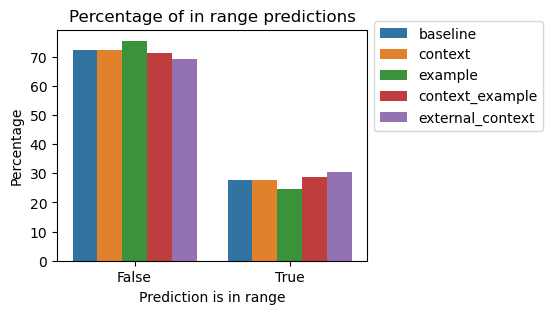

In [98]:
# plot percentage of true results in combined_in_range_counts
plt.figure(figsize=(4, 3))

ax = sns.barplot(
    x="top_k_majority_in_range",
    y="percentage",
    hue="model",
    data=combined_in_range_counts,
)

ax.set_title("Percentage of in range predictions")

ax.set_xlabel("Prediction is in range")
ax.set_ylabel("Percentage")

# move legend to right side
ax.legend(loc='center left', bbox_to_anchor=(1, 0.8))

plt.show()

In [99]:
true_counts = combined_in_range_counts[combined_in_range_counts["top_k_majority_in_range"]]
true_counts

,top_k_majority_in_range,count,percentage,model
1,True,27,27.55,baseline
1,True,27,27.55,context
1,True,24,24.49,example
1,True,28,28.57,context_example
1,True,30,30.61,external_context


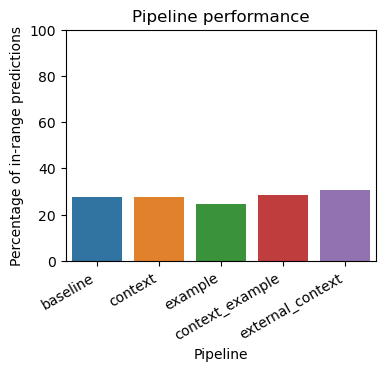

In [101]:
# plot percentage against model in true_counts using seaborn
plt.figure(figsize=(4, 3))

ax = sns.barplot(
    x="model", 
    y="percentage", 
    data=true_counts,
)

ax.set_title("Pipeline performance")
ax.set_xlabel("Pipeline")
ax.set_ylabel("Percentage of in-range predictions")

# set x-tick labels to 45 degrees and align with tick
for item in ax.get_xticklabels():
    item.set_rotation(30)
    item.set_ha("right")

plt.ylim(0, 100)

plt.show()